# More is better

In [1]:
import pandas as pd
import numpy as np
import dprocessing as dp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [2]:
sns.set()

In [3]:
X, y = make_blobs(n_samples = 300, centers = 4, random_state = 0, cluster_std = 1.0)

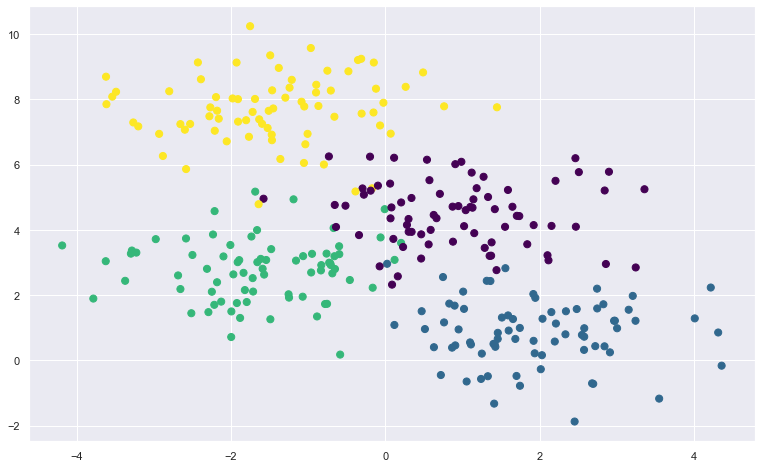

In [4]:
fig, ax = plt.subplots(figsize = (13, 8))
ax.scatter(X[:, 0], X[:, 1], c = y, s = 50, cmap = 'viridis');

In [5]:
def visualize_tree(estimator, X, y, xlim = None, ylim = None, ax = None):

    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c = y, s = 30, cmap = 'viridis') 

   
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num = 200),
                         np.linspace(*ylim, num = 200))
    
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha = 0.3,
                           levels = np.arange(n_classes + 1) - 0.5,
                           cmap = 'viridis') 

In [6]:
a, b = np.meshgrid(np.arange(-2, 2), np.arange(-2, 2)) 

In [7]:
a.ravel()

array([-2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1])

In [8]:
np.c_[a.ravel(), b.ravel()]

array([[-2, -2],
       [-1, -2],
       [ 0, -2],
       [ 1, -2],
       [-2, -1],
       [-1, -1],
       [ 0, -1],
       [ 1, -1],
       [-2,  0],
       [-1,  0],
       [ 0,  0],
       [ 1,  0],
       [-2,  1],
       [-1,  1],
       [ 0,  1],
       [ 1,  1]])

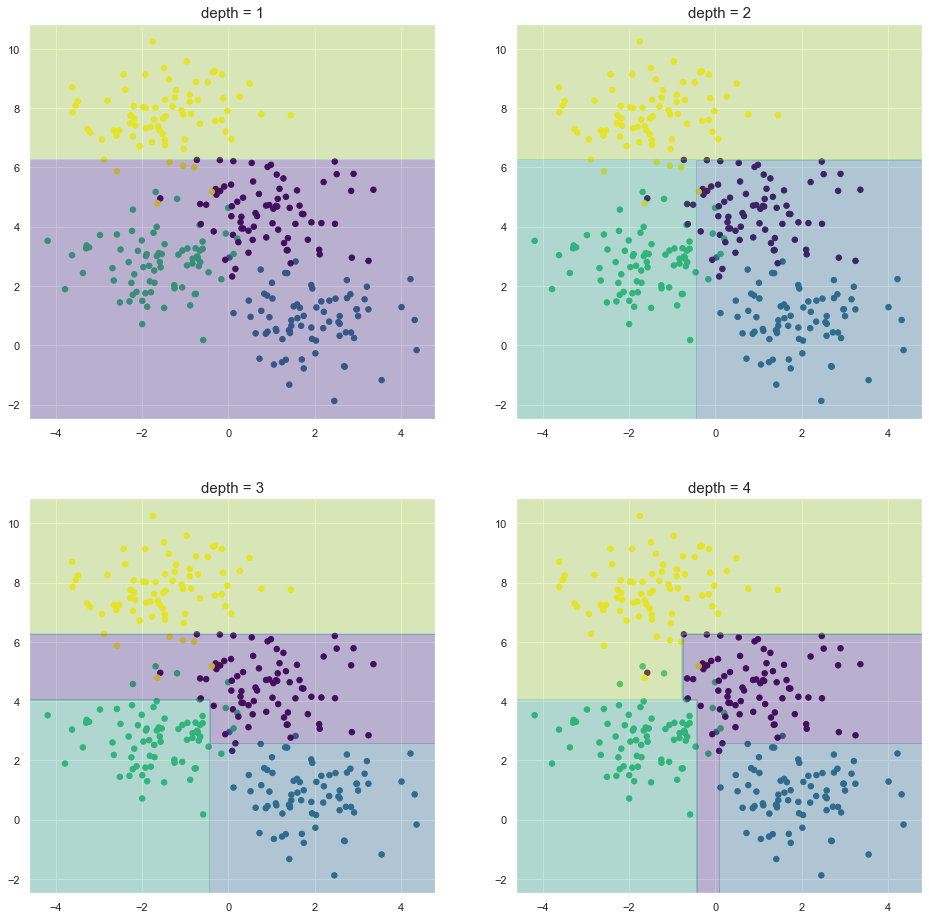

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))



for axi, depth in zip(ax.flat, range(1, 5)):
    model = DecisionTreeClassifier(max_depth = depth)
    visualize_tree(model, X, y, ax = axi)
    axi.set_title('depth = {0}'.format(depth), fontsize = 15)

## Visualize Decision Tree

To get a sense of how the decision tree "thinks", it's helpful to visualize the entire structure. This will show each node in the tree which we can use to make new predictions. Because the tree is relatively small, we can understand the entire image.

First we export the tree as a dot file making sure to label the features and the classes.

In [10]:
from sklearn.tree import export_graphviz 

In [11]:
tree = DecisionTreeClassifier(max_depth = 4)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=4)

In [12]:
# Export as dot
export_graphviz(tree, 'tree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1', '2', '3'], filled = True)

In [13]:
import graphviz #pip install graphviz 

[graphviz](https://graphviz.org/download/) if rise an error

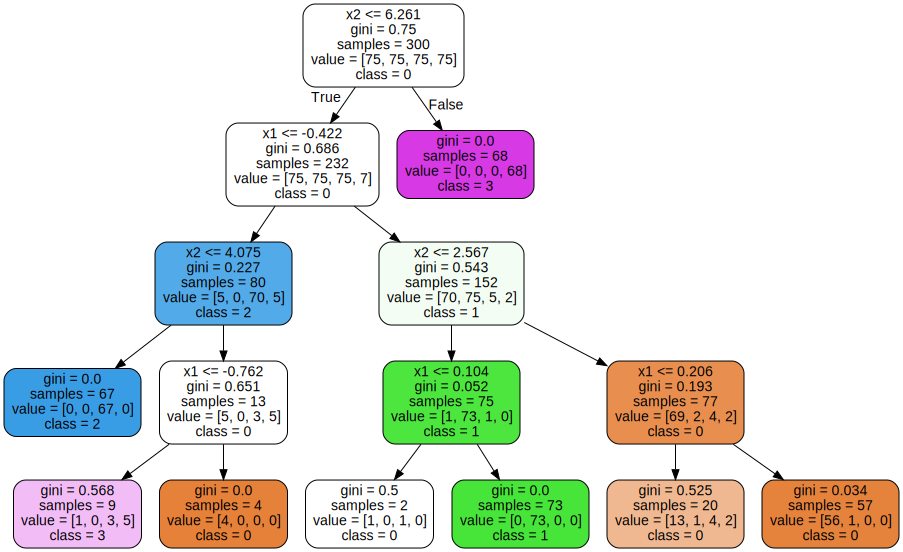

In [14]:
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

All the nodes, except the leaf nodes (colored terminal nodes), have 5 parts:


- Question asked about the data based on a value of a feature. Each question has either a True or False answer that splits the node. Based on the answer to the question, a data point moves down the tree.


- gini: The Gini Impurity of the node. The average weighted Gini Impurity decreases as we move down the tree.


- samples: The number of observations in the node.


- value: The number of samples in each class. For example, the top node has 75 samples in class 0 and 75 samples in class 1, etc.


- class: The majority classification for points in the node. In the case of leaf nodes, this is the prediction for all samples in the node.



The leaf nodes do not have a question because these are where the final predictions are made. To classify a new point, simply move down the tree, using the features of the point to answer the questions until you arrive at a leaf node where the class is the prediction.

In [15]:
tree = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [16]:
export_graphviz(tree, 'tree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1', '2', '3'], filled = True)

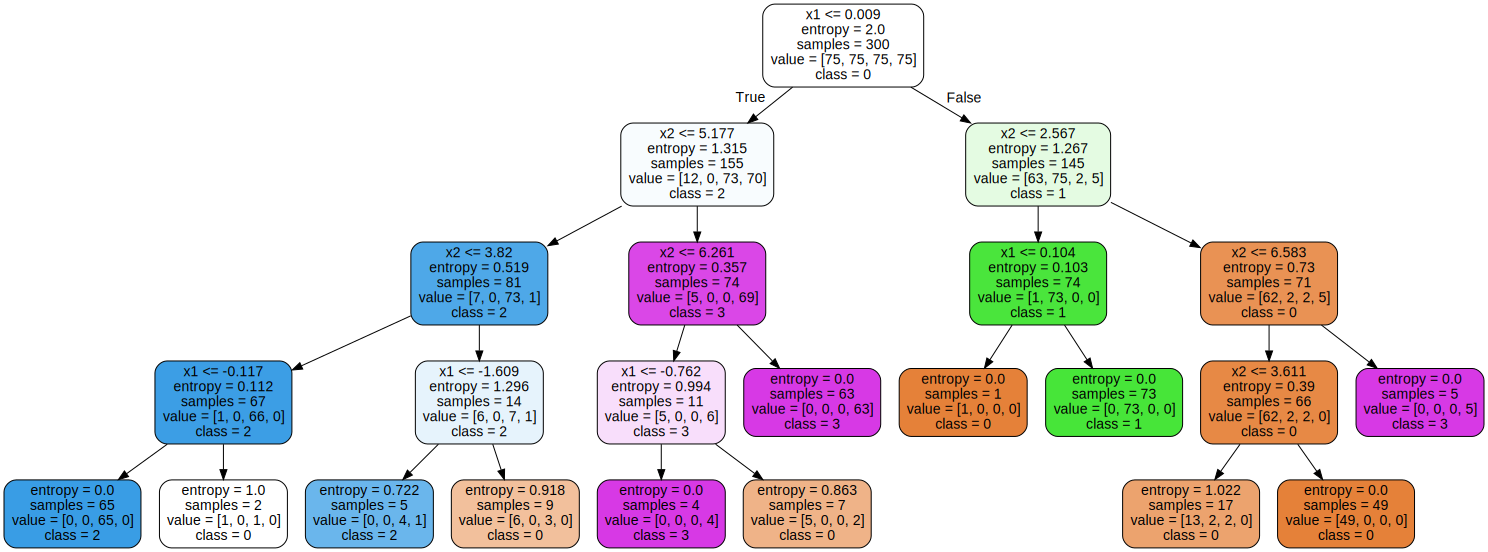

In [17]:
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## Problems with trees

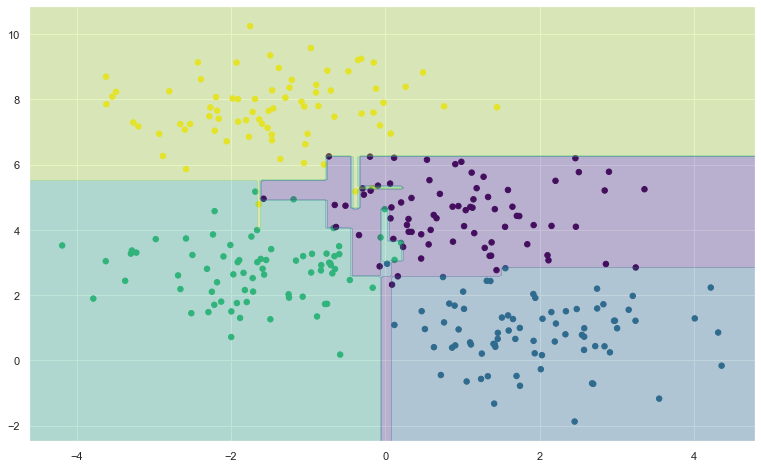

In [18]:
fig, ax = plt.subplots(figsize = (13, 8))
visualize_tree(DecisionTreeClassifier(), X, y, ax = ax)

Notice that as the depth increases, we tend to get very strangely shaped classification regions. It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data. That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

## Decision trees and over-fitting


Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from. Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data:

In [19]:
model = DecisionTreeClassifier()

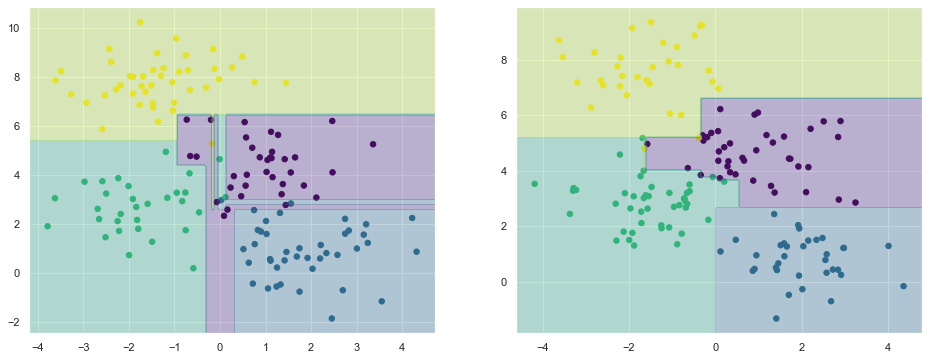

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))

visualize_tree(model, X[ ::2], y[ ::2], ax = ax[0])
visualize_tree(model, X[1::2], y[1::2], ax = ax[1])

In [21]:
a = [i for i in range(15)]
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [22]:
a[::2]

[0, 2, 4, 6, 8, 10, 12, 14]

In [23]:
a[1::2]

[1, 3, 5, 7, 9, 11, 13]

It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters). The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from both of these trees, we might come up with a better result.

Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

# Ensembles of Estimators: Random Forests


This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called bagging. Bagging makes use of an ensemble of parallel estimators, each of which over-fits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a random forest.


<img src = https://img.vixdata.io/pd/webp-large/es/sites/default/files/btg/cine.batanga.com/files/5-razones-por-las-que-Bilbo-es-mejor-personaje-que-Frodo.jpg>

In [25]:
from sklearn.ensemble import BaggingClassifier

In [26]:
tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators = 100, max_samples = 0.8,
                        random_state = 1)

In [27]:
bag.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.8,
                  n_estimators=100, random_state=1)

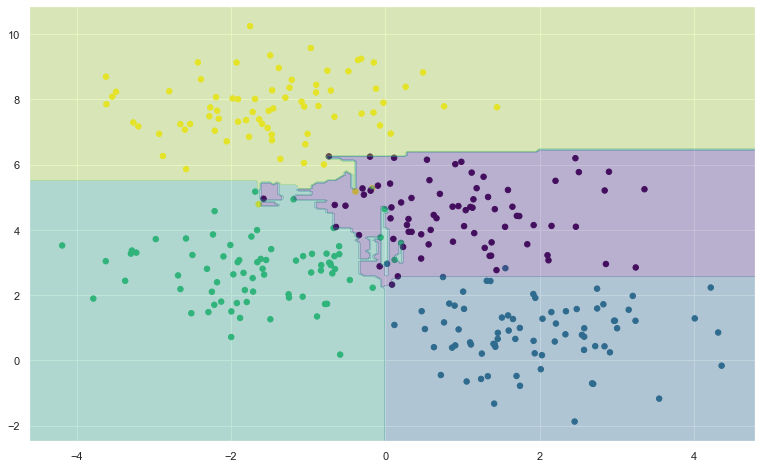

In [28]:
fig, ax = plt.subplots(figsize = (13, 8))
visualize_tree(bag, X, y, ax = ax);

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points. In practice trees are more effectively randomized by building them on a random subset of characteristics from our data.

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
cls = RandomForestClassifier(n_estimators = 100, random_state = 0)

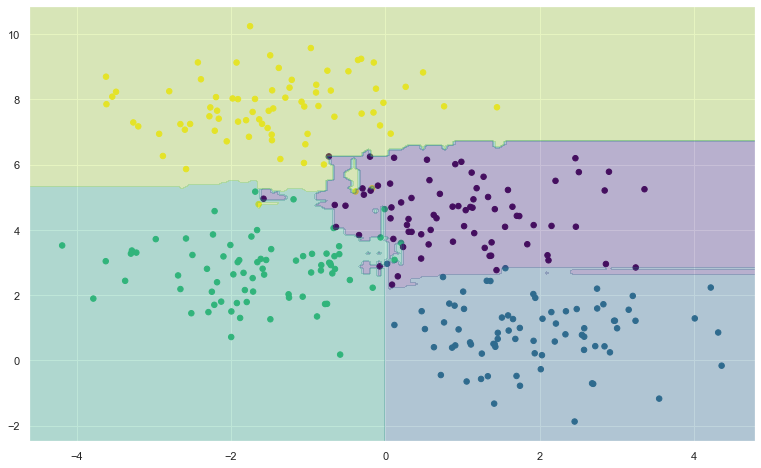

In [31]:
fig, ax = plt.subplots(figsize = (13, 8))
visualize_tree(cls, X, y, ax = ax);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification. Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the RandomForestRegressor, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

In [42]:
rng = np.random.RandomState(42)
x = np.linspace(-3, 10, 300)

In [43]:
def model(x, sigma = 0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)

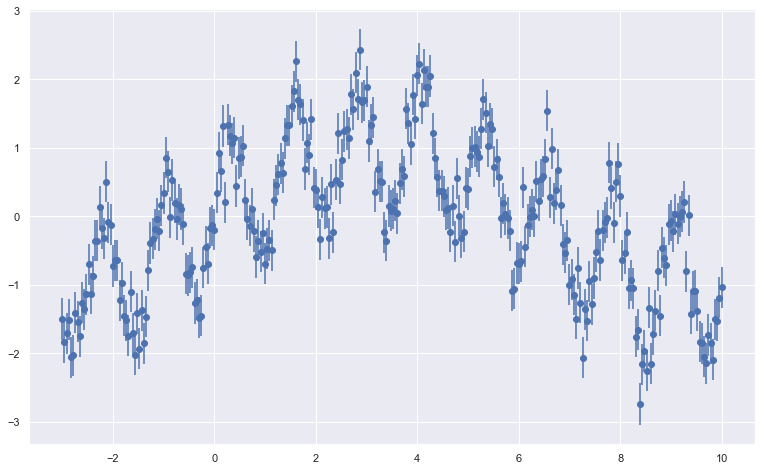

In [44]:
fig, ax = plt.subplots(figsize = (13, 8))
ax.errorbar(x, y, 0.3, fmt = 'o');

Using the random forest regressor, we can find the best fit curve as follows:

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
forest = RandomForestRegressor(200)

In [47]:
x[:, None]

array([[-3.        ],
       [-2.95652174],
       [-2.91304348],
       [-2.86956522],
       [-2.82608696],
       [-2.7826087 ],
       [-2.73913043],
       [-2.69565217],
       [-2.65217391],
       [-2.60869565],
       [-2.56521739],
       [-2.52173913],
       [-2.47826087],
       [-2.43478261],
       [-2.39130435],
       [-2.34782609],
       [-2.30434783],
       [-2.26086957],
       [-2.2173913 ],
       [-2.17391304],
       [-2.13043478],
       [-2.08695652],
       [-2.04347826],
       [-2.        ],
       [-1.95652174],
       [-1.91304348],
       [-1.86956522],
       [-1.82608696],
       [-1.7826087 ],
       [-1.73913043],
       [-1.69565217],
       [-1.65217391],
       [-1.60869565],
       [-1.56521739],
       [-1.52173913],
       [-1.47826087],
       [-1.43478261],
       [-1.39130435],
       [-1.34782609],
       [-1.30434783],
       [-1.26086957],
       [-1.2173913 ],
       [-1.17391304],
       [-1.13043478],
       [-1.08695652],
       [-1

In [48]:
forest.fit(x[:, None], y)

RandomForestRegressor(n_estimators=200)

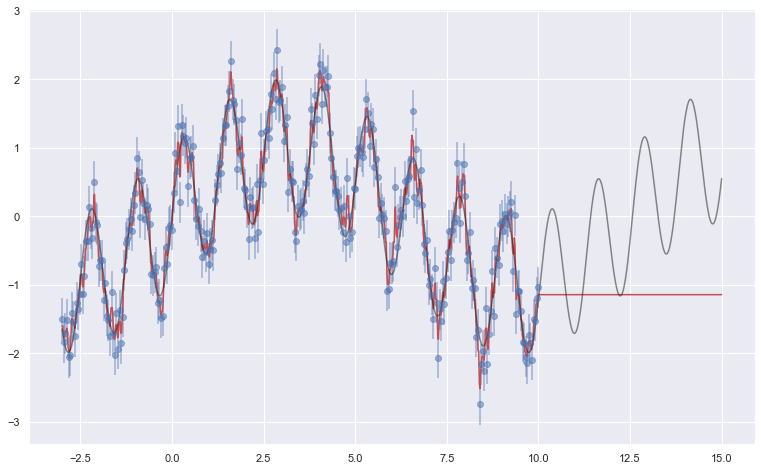

In [49]:
fig, ax = plt.subplots(figsize = (13, 8))
xfit = np.linspace(-3, 15, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma = 0)

ax.errorbar(x, y, 0.3, fmt = 'o', alpha = 0.5)
ax.plot(xfit, yfit, '-r');
ax.plot(xfit, ytrue, '-k', alpha = 0.5);

In [50]:
forest.score(xfit[:, None], ytrue)

0.4056693729353188

## Example: Random Forest for Classifying Digits



In [51]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [54]:
digits;

In [55]:
digits['data']

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [56]:
digits['data'].shape

(1797, 64)

In [57]:
digits['images']

array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
        [ 0.,  0., 13., ..., 15.,  5.,  0.],
        [ 0.,  3., 15., ..., 11.,  8.,  0.],
        ...,
        [ 0.,  4., 11., ..., 12.,  7.,  0.],
        [ 0.,  2., 14., ..., 12.,  0.,  0.],
        [ 0.,  0.,  6., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
        [ 0.,  0.,  0., ...,  9.,  0.,  0.],
        [ 0.,  0.,  3., ...,  6.,  0.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., 12.,  0.,  0.],
        [ 0.,  0.,  3., ..., 14.,  0.,  0.],
        [ 0.,  0.,  8., ..., 16.,  0.,  0.],
        ...,
        [ 0.,  9., 16., ...,  0.,  0.,  0.],
        [ 0.,  3., 13., ..., 11.,  5.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.]],

       ...,

       [[ 0.,  0.,  1., ...,  1.,  0.,  0.],
        [ 0.,  0., 13., ...,  2.,  1.,  0.],
        [ 0.,  0., 16., ..., 16.,  5.,  0.

In [58]:
digits['images'].shape

(1797, 8, 8)

In [72]:
digits['images'][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

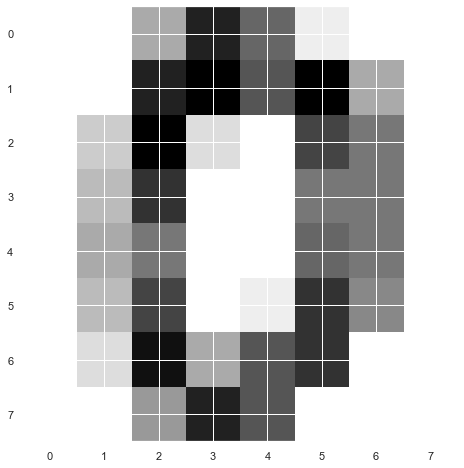

In [59]:
fig, ax = plt.subplots(figsize = (13, 8))
ax.imshow(digits['images'][0], cmap = plt.cm.binary);

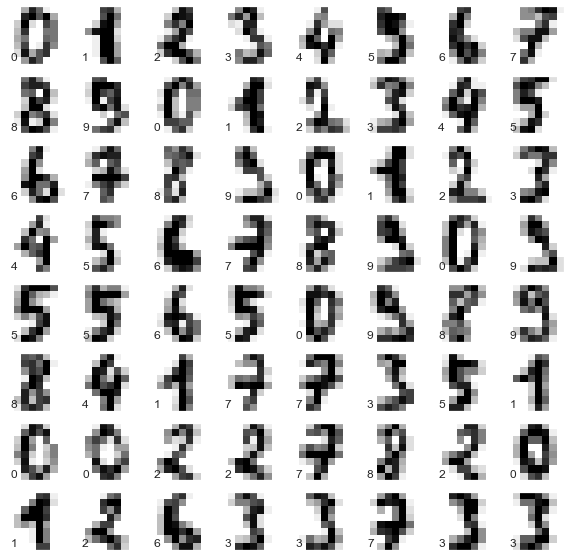

In [60]:
# set up the figure
fig = plt.figure(figsize = (10, 10))  # figure size in inches

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap = plt.cm.binary)
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
Xtrain, Xtest, ytrain, ytest = train_test_split(digits['data'], digits['target'],
                                                random_state = 0)

In [63]:
model = RandomForestClassifier(n_estimators = 1000)

In [64]:
model.fit(Xtrain, ytrain)

RandomForestClassifier(n_estimators=1000)

In [65]:
ypred = model.predict(Xtest)

In [66]:
ypred

array([2, 8, 2, 6, 6, 7, 1, 9, 8, 5, 2, 8, 6, 6, 6, 6, 1, 0, 5, 8, 8, 7,
       8, 4, 7, 5, 4, 9, 2, 9, 4, 7, 6, 8, 9, 4, 3, 1, 0, 1, 8, 6, 7, 7,
       1, 0, 7, 6, 2, 1, 9, 6, 7, 9, 0, 0, 5, 1, 6, 3, 0, 2, 3, 4, 1, 9,
       2, 6, 9, 1, 8, 3, 5, 1, 2, 8, 2, 2, 9, 7, 2, 3, 6, 0, 5, 3, 7, 5,
       1, 2, 9, 9, 3, 1, 7, 7, 4, 8, 5, 8, 5, 5, 2, 5, 9, 0, 7, 1, 4, 7,
       3, 4, 8, 9, 7, 9, 8, 0, 6, 5, 2, 5, 3, 4, 1, 7, 0, 6, 1, 5, 5, 9,
       9, 5, 9, 9, 5, 7, 5, 6, 2, 8, 6, 9, 6, 1, 5, 1, 5, 9, 9, 1, 5, 3,
       6, 1, 8, 9, 7, 7, 6, 7, 6, 5, 6, 0, 8, 8, 9, 8, 6, 1, 0, 4, 1, 6,
       3, 8, 6, 7, 4, 9, 6, 3, 0, 3, 3, 3, 0, 7, 7, 5, 7, 8, 0, 7, 8, 9,
       6, 4, 5, 0, 1, 4, 6, 4, 3, 3, 0, 9, 5, 9, 2, 1, 4, 2, 1, 6, 8, 9,
       2, 4, 9, 3, 7, 6, 2, 3, 3, 1, 6, 9, 3, 6, 3, 2, 2, 0, 7, 6, 1, 1,
       9, 7, 2, 7, 8, 5, 5, 7, 5, 2, 3, 7, 2, 7, 5, 5, 7, 0, 9, 1, 6, 5,
       9, 7, 4, 3, 8, 0, 3, 6, 4, 6, 3, 1, 6, 8, 8, 8, 4, 6, 7, 5, 2, 4,
       5, 3, 2, 4, 6, 9, 4, 5, 4, 3, 4, 6, 2, 9, 0,

In [67]:
from sklearn import metrics

In [68]:
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.96      0.98        45
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [69]:
from sklearn.metrics import confusion_matrix

In [70]:
mat = confusion_matrix(ytest, ypred)

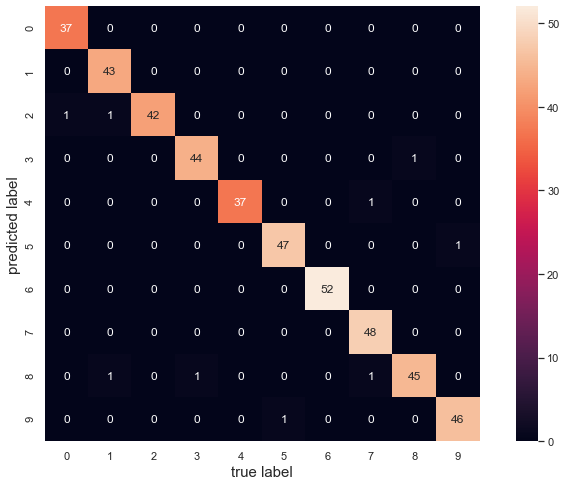

In [71]:
fig, ax = plt.subplots(figsize = (13, 8))
sns.heatmap(mat, square = True, annot = True, fmt = 'd', ax = ax)
ax.set_xlabel('true label', fontsize = 15)
ax.set_ylabel('predicted label', fontsize = 15);

# Example

I try to make predictions where the prediction task is to determine whether a person makes over 50K a year.

In [73]:
import warnings

warnings.filterwarnings('ignore')

In [74]:
df = pd.read_csv('income_evaluation.csv')

In [75]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [76]:
df.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32559,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32560 non-null  int64 
 1    workclass       32560 non-null  object
 2    fnlwgt          32560 non-null  int64 
 3    education       32560 non-null  object
 4    education-num   32560 non-null  int64 
 5    marital-status  32560 non-null  object
 6    occupation      32560 non-null  object
 7    relationship    32560 non-null  object
 8    race            32560 non-null  object
 9    sex             32560 non-null  object
 10   capital-gain    32560 non-null  int64 
 11   capital-loss    32560 non-null  int64 
 12   hours-per-week  32560 non-null  int64 
 13   native-country  32560 non-null  object
 14   income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [78]:
df.shape

(32560, 15)

In [79]:
df.columns

Index(['age', ' workclass', ' fnlwgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' income'],
      dtype='object')

In [80]:
df.columns = df.columns.str.strip()

df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [81]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

## Explore Categorical Variables 

In [82]:
categorical = [var for var in df.columns if df[var].dtype == 'O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n')
for c in categorical:
    print(c)

There are 9 categorical variables

The categorical variables are :


workclass
education
marital-status
occupation
relationship
race
sex
native-country
income


In [83]:
df[categorical].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [84]:
for var in categorical: 
    
    print(df[var].value_counts())

 Private             22695
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
 HS-grad         10501
 Some-college     7290
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64
 Married-civ-spouse       14976
 Never-married            10682
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial

In [85]:
# check for missing values

df['income'].isnull().sum()

0

In [86]:
# view number of unique values

df['income'].nunique()

2

In [87]:
# view the unique values

df['income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [90]:
df['income'] = df['income'].str.strip()

In [91]:
df['income'].nunique()

2

In [92]:
df['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [88]:
# view the frequency distribution of values

df['income'].value_counts()

 <=50K    24719
 >50K      7841
Name: income, dtype: int64

In [93]:
# view percentage of frequency distribution of values

df['income'].value_counts() / len(df)

<=50K    0.759183
>50K     0.240817
Name: income, dtype: float64

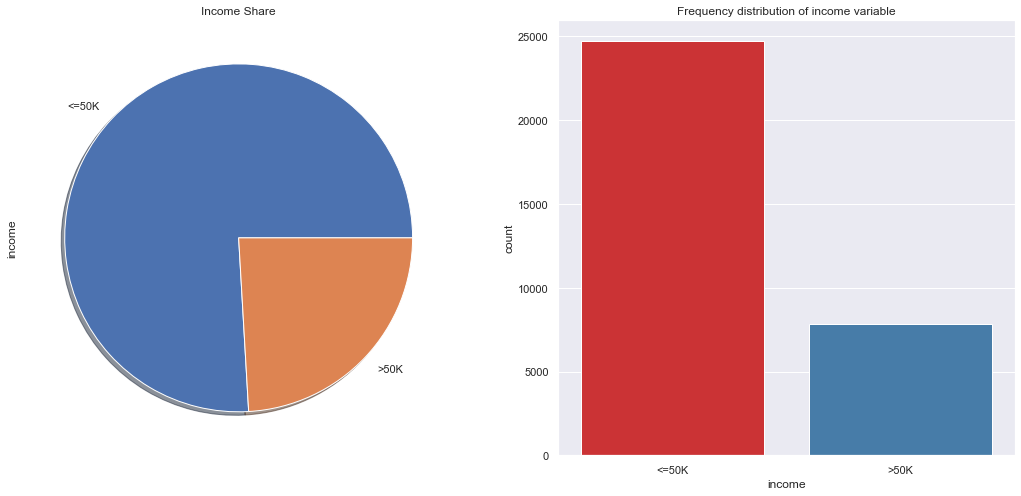

In [94]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

df['income'].value_counts().plot.pie(explode = [0,0], ax = ax[0],shadow = True)
ax[0].set_title('Income Share')


sns.countplot(x = "income", data = df, palette = "Set1", ax = ax[1])
ax[1].set_title("Frequency distribution of income variable");

#### Visualize `income` x `sex` variable

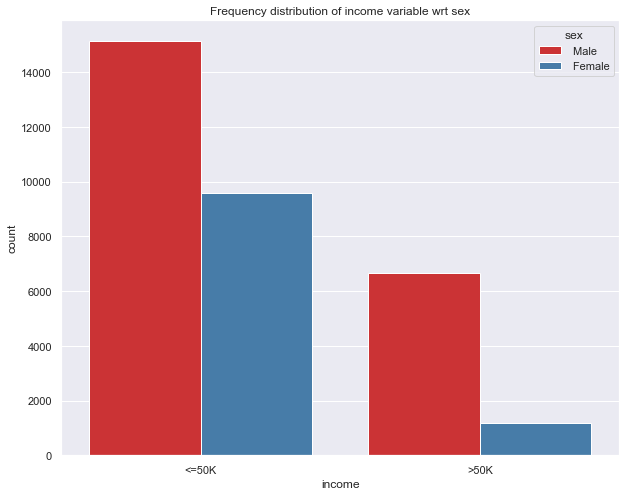

In [95]:
f, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x="income", hue="sex", data=df, palette="Set1", ax = ax)
ax.set_title("Frequency distribution of income variable wrt sex");

#### Interpretation


- We can see that males make more money than females in both the income categories.

#### Visualize `income` x `race`

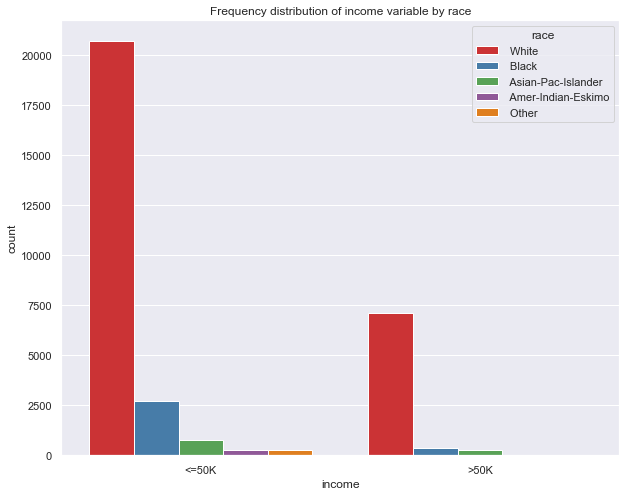

In [96]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x = "income", hue = "race", data = df, palette = "Set1", ax = ax)
ax.set_title("Frequency distribution of income variable by race");

#### Interpretation


- We can see that whites make more money than non-whites in both the income categories.

In [98]:
# check number of unique labels 
df['workclass'].nunique()

9

In [99]:
# view the unique labels

df.workclass.unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [100]:
# view frequency distribution of values

df.workclass.value_counts()

 Private             22695
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

We can see that there are 1836 values encoded as `?` in workclass variable. I will replace these `?` with `NaN`.

In [101]:
# replace '?' values in workclass variable with `NaN`

df['workclass'].replace(' ?', np.NaN, inplace = True)

In [102]:
# again check the frequency distribution of values in workclass variable

df.workclass.value_counts()

 Private             22695
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

#### Visualize `workclass` variable

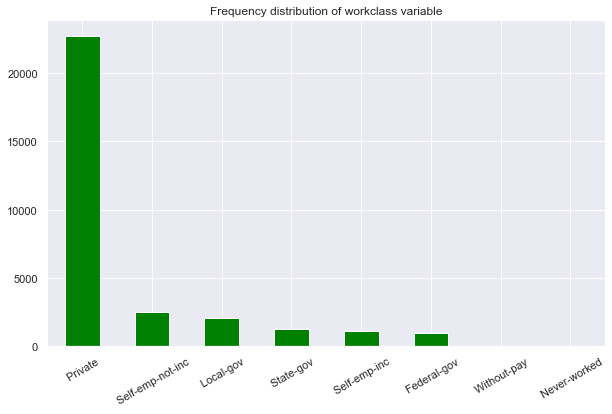

In [103]:
fig, ax = plt.subplots(figsize = (10, 6))
df.workclass.value_counts().plot(kind="bar", color="green", ax = ax)
ax.set_title("Frequency distribution of workclass variable")
ax.set_xticklabels(df.workclass.value_counts().index, rotation = 30);

#### Visualize `workclass` variable wrt `sex` variable

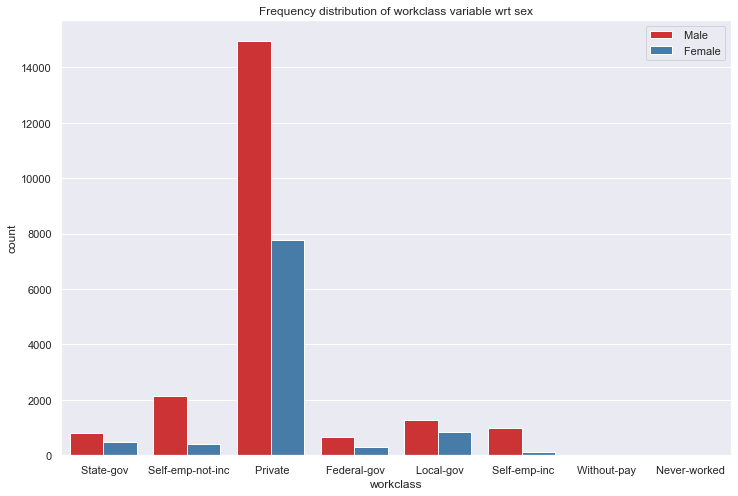

In [104]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.countplot(x = "workclass", hue = "sex", data = df, palette = "Set1", ax = ax)
ax.set_title("Frequency distribution of workclass variable wrt sex")
ax.legend(loc = 'upper right');

#### Interpretation


- We can see that there are more male workers than female workers in all the working category.

- The trend is more appealing in Private sector.

#### Explore `occupation` variable

In [105]:
# check number of unique labels

df.occupation.nunique()

15

In [106]:
# view unique labels

df.occupation.unique()


array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [107]:
# view frequency distribution of values

df.occupation.value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2001
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

We can see that there are 1843 values encoded as `?` in occupation variable. I will replace these `?` with `NaN`.

In [108]:
# replace '?' values in occupation variable with `NaN`

df['occupation'].replace(' ?', np.NaN, inplace = True)


In [109]:
# again check the frequency distribution of values

df['occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2001
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

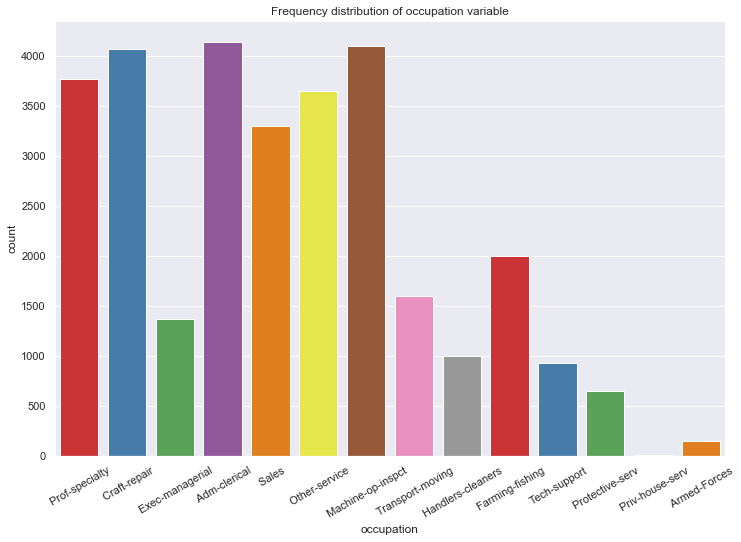

In [110]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.countplot(x = "occupation", data = df, palette = "Set1", ax = ax)
ax.set_title("Frequency distribution of occupation variable")
ax.set_xticklabels(df.occupation.value_counts().index, rotation = 30);

#### Explore `native_country` variable

In [111]:
# check number of unique labels

df['native-country'].nunique()

41

In [112]:
# view unique labels 

df['native-country'].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary'], dtype=object)

In [113]:
# check frequency distribution of values

df['native-country'].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

We can see that there are 583 values encoded as `?` in native_country variable. I will replace these `?` with `NaN`.

In [114]:
# replace '?' values in native_country variable with `NaN`


df['native-country'].replace(' ?', np.NaN, inplace = True)

In [115]:
# again check the frequency distribution of values

df['native-country'].value_counts()

 United-States                 29170
 Mexico                          643
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 Greece                           29
 

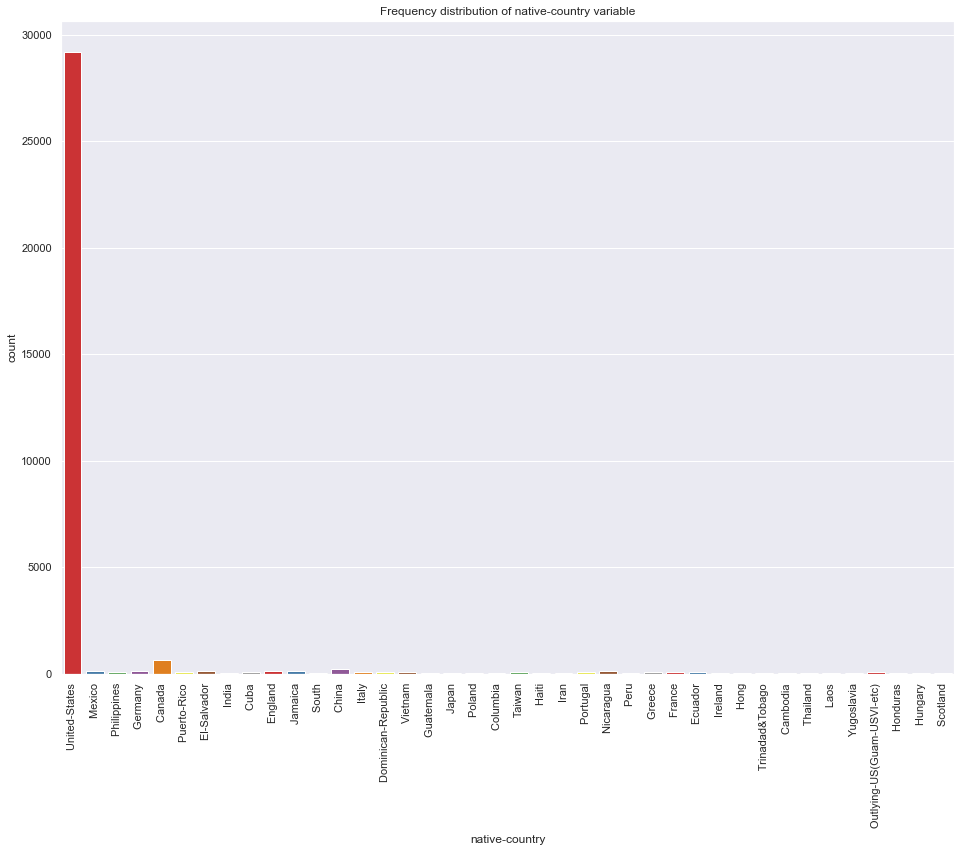

In [116]:
fig, ax = plt.subplots(figsize = (16, 12))
sns.countplot(x = "native-country", data = df, palette = "Set1", ax = ax)
ax.set_title("Frequency distribution of native-country variable")
ax.set_xticklabels(df['native-country'].value_counts().index, rotation = 90);

We can see that `United-States` dominate amongst the `native_country` variables.

In [117]:
df[categorical].isnull().sum()

workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
native-country     583
income               0
dtype: int64

### Number of labels: Cardinality 

- The number of labels within a categorical variable is known as **cardinality**. 

- A high number of labels within a variable is known as **high cardinality**. 

- High cardinality may pose some serious problems in the machine learning model. So, I will check for high cardinality.

In [118]:
# check for cardinality in categorical variables
msn = '{:20} contains {:2} labels'
for var in categorical:
    
    print(msn.format(var, len(df[var].unique())))

workclass            contains  9 labels
education            contains 16 labels
marital-status       contains  7 labels
occupation           contains 15 labels
relationship         contains  6 labels
race                 contains  5 labels
sex                  contains  2 labels
native-country       contains 41 labels
income               contains  2 labels


We can see that native_country column contains relatively large number of labels as compared to other columns.

In [119]:
numerical = [var for var in df.columns if df[var].dtype!='O']

print('There are {} categorical variables\n'.format(len(numerical)))

print('The categorical variables are :\n\n')
for c in numerical:
    print(c)

There are 6 categorical variables

The categorical variables are :


age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week


In [120]:
df[numerical].head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [121]:
df[numerical].isnull().sum()

age               0
fnlwgt            0
education-num     0
capital-gain      0
capital-loss      0
hours-per-week    0
dtype: int64

In [124]:
df[numerical].describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581849,1.897833e+05,10.080682,1077.681941,87.238790,40.437469
std,13.640593,1.055478e+05,2.572760,7385.403083,402.795459,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#### Explore `age` variable

In [122]:
df['age'].nunique()

73

#### View the distribution of `age` variable

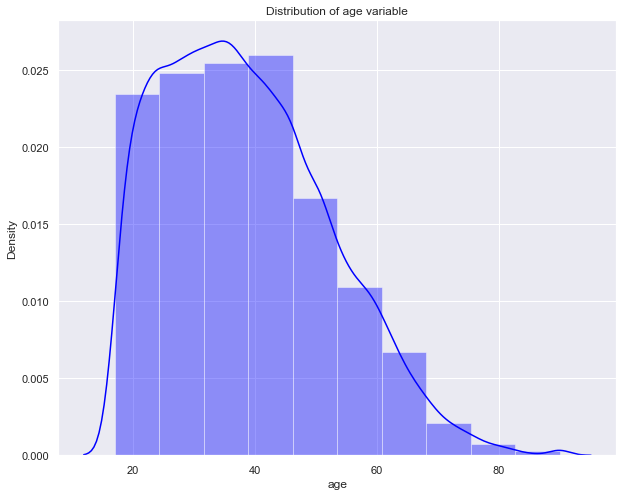

In [125]:
fig, ax = plt.subplots(figsize = (10,8))
x = df['age']
sns.distplot(x, bins = 10, color = 'blue', ax = ax)
ax.set_title("Distribution of age variable");

We can see that `age` is slightly positively skewed.

#### Detect outliers in `age` variable with boxplot

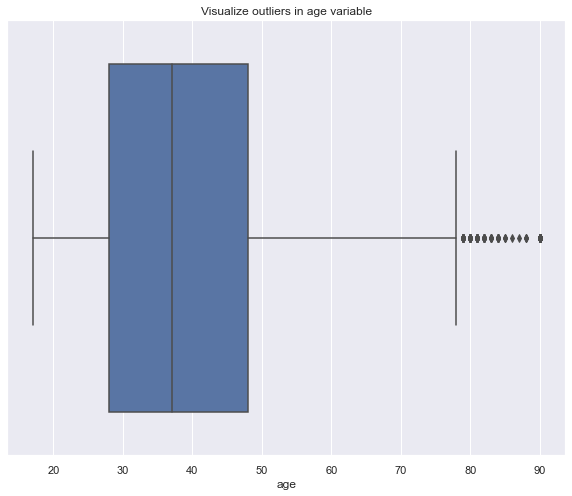

In [126]:
fig, ax = plt.subplots(figsize = (10,8))
x = df['age']
sns.boxplot(x, ax = ax)
ax.set_title("Visualize outliers in age variable");

We can see that there are lots of outliers in `age` variable.

#### Explore relationship between `age` and `income` variables

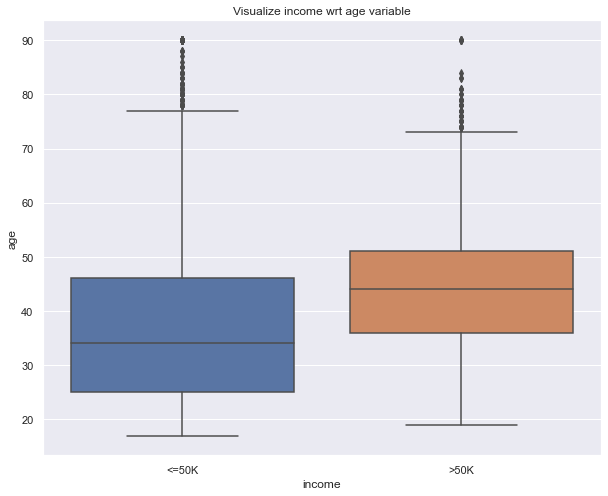

In [127]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(x = "income", y = "age", data = df, ax = ax)
ax.set_title("Visualize income wrt age variable");

#### Interpretation

- As expected, younger people make less money as compared to senior people.

#### Visualize `income` wrt `age` and `sex` variable

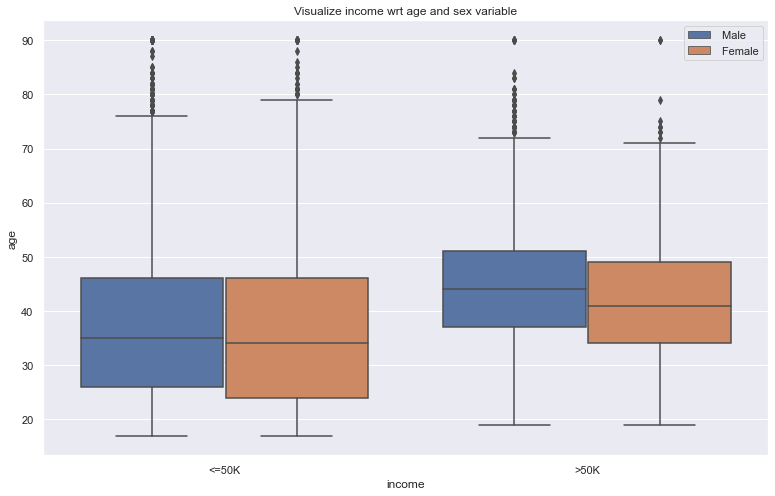

In [128]:
fig, ax = plt.subplots(figsize = (13, 8))
sns.boxplot(x = "income", y = "age", hue = "sex", data = df, ax = ax)
ax.set_title("Visualize income wrt age and sex variable")
ax.legend(loc = 'upper right');

<Figure size 576x432 with 0 Axes>

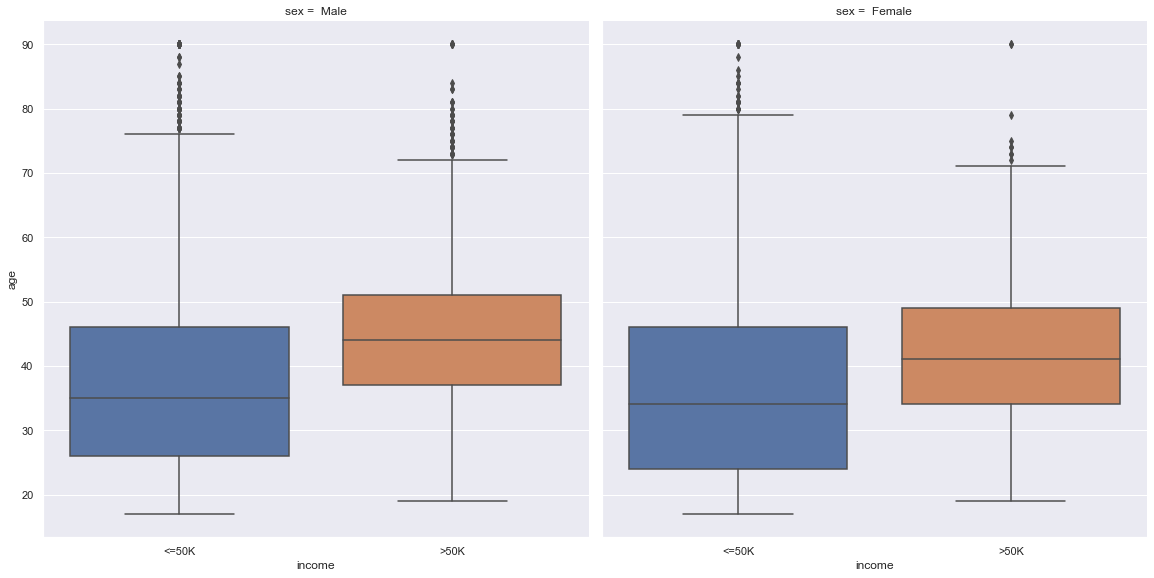

In [129]:
plt.figure(figsize = (8,6))
sns.catplot(x = "income", y = "age", col = "sex", data = df, kind = "box",
            height = 8, aspect = 1, ax = ax);

#### Interpretation

- Senior people make more money than younger people.

#### Find out the correlations

In [130]:
# plot correlation heatmap to find out correlations

df.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076672,0.036527,0.077673,0.057877,0.068755
fnlwgt,-0.076672,1.000000,-0.043198,0.000425,-0.010009,-0.018771
education-num,0.036527,-0.043198,1.000000,0.122630,0.079962,0.148123
capital-gain,0.077673,0.000425,0.122630,1.000000,-0.031605,0.078408
capital-loss,0.057877,-0.010009,0.079962,-0.031605,1.000000,0.054285
hours-per-week,0.068755,-0.018771,0.148123,0.078408,0.054285,1.000000


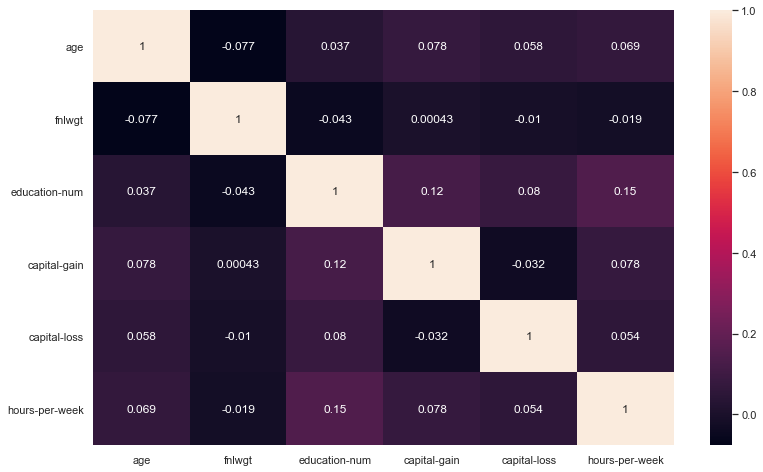

In [131]:
fig, ax = plt.subplots(figsize = (13, 8))
sns.heatmap(df.corr(), annot = True, ax = ax);

#### Interpretation

- We can see that there is no strong correlation between variables.

#### Plot pairwise relationships in dataset

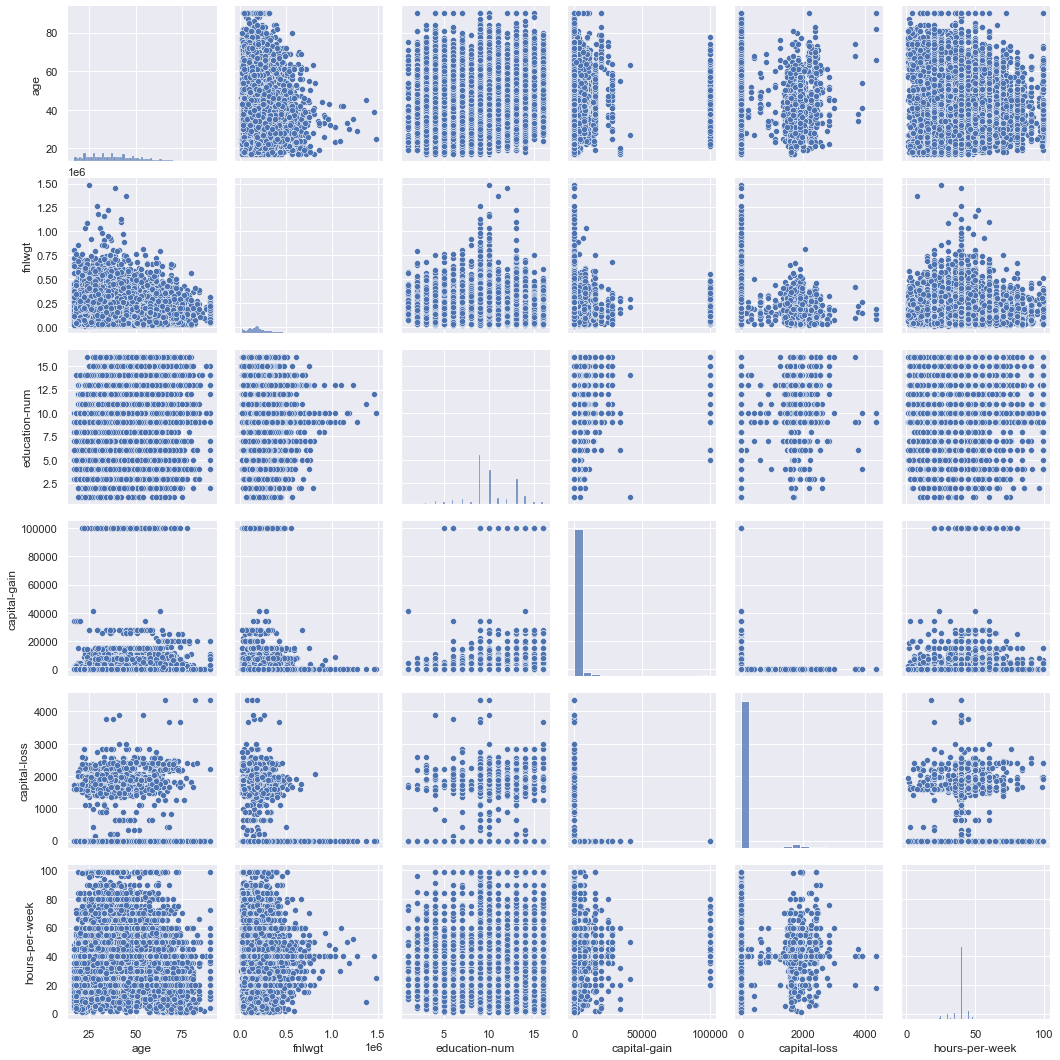

In [132]:
sns.pairplot(df);

### Declare feature vector and target variable 

In [133]:
X = df.drop(['income'], axis = 1)

y = df['income']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [135]:
X_train.shape, X_test.shape

((22792, 14), (9768, 14))

### Feature Engineering 

In [136]:
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']

categorical

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [137]:
numerical

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [138]:
X_train[categorical].isnull().mean()

workclass         0.056248
education         0.000000
marital-status    0.000000
occupation        0.056423
relationship      0.000000
race              0.000000
sex               0.000000
native-country    0.018252
dtype: float64

In [139]:
# impute missing categorical variables with most frequent value

for df2 in [X_train, X_test]:
    df2['workclass'].fillna(X_train['workclass'].mode()[0], inplace = True)
    df2['occupation'].fillna(X_train['occupation'].mode()[0], inplace = True)
    df2['native-country'].fillna(X_train['native-country'].mode()[0], inplace = True)    

In [140]:
# check missing values in categorical variables in X_train

X_train[categorical].isnull().sum()

workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
native-country    0
dtype: int64

In [141]:
# check missing values in categorical variables in X_test

X_test[categorical].isnull().sum()

workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
native-country    0
dtype: int64

As a final check, I will check for missing values in X_train and X_test.

In [142]:
# check missing values in X_train

X_train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

In [143]:
# check missing values in X_test

X_test.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

We can see that there are no missing values in X_train and X_test.

### Encode categorical variables

In [144]:
categorical

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [145]:
X_train[categorical].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
20721,Self-emp-inc,Some-college,Married-civ-spouse,Transport-moving,Husband,Black,Male,Haiti
32097,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
25205,State-gov,HS-grad,Divorced,Adm-clerical,Unmarried,White,Female,United-States
23491,Private,Bachelors,Never-married,Farming-fishing,Not-in-family,White,Male,United-States
12367,Private,HS-grad,Never-married,Craft-repair,Not-in-family,White,Male,Guatemala


In [146]:
import category_encoders as ce #conda install -c conda-forge category_encoders

In [147]:
encoder = ce.OneHotEncoder(cols = categorical)

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

In [148]:
X_train.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native-country_31,native-country_32,native-country_33,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40
20721,32,1,0,0,0,0,0,0,0,343872,...,0,0,0,0,0,0,0,0,0,0
32097,45,0,1,0,0,0,0,0,0,170871,...,0,0,0,0,0,0,0,0,0,0
25205,47,0,0,1,0,0,0,0,0,108890,...,0,0,0,0,0,0,0,0,0,0
23491,37,0,1,0,0,0,0,0,0,61778,...,0,0,0,0,0,0,0,0,0,0
12367,29,0,1,0,0,0,0,0,0,145592,...,0,0,0,0,0,0,0,0,0,0


In [149]:
X_train.columns

Index(['age', 'workclass_1', 'workclass_2', 'workclass_3', 'workclass_4',
       'workclass_5', 'workclass_6', 'workclass_7', 'workclass_8', 'fnlwgt',
       ...
       'native-country_31', 'native-country_32', 'native-country_33',
       'native-country_34', 'native-country_35', 'native-country_36',
       'native-country_37', 'native-country_38', 'native-country_39',
       'native-country_40'],
      dtype='object', length=104)

In [150]:
X_train.shape

(22792, 104)

In [151]:
X_test.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native-country_31,native-country_32,native-country_33,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40
22278,40,1,0,0,0,0,0,0,0,193524,...,0,0,0,0,0,0,0,0,0,0
8950,27,0,1,0,0,0,0,0,0,216481,...,0,0,0,0,0,0,0,0,0,0
7838,25,0,1,0,0,0,0,0,0,256263,...,0,0,0,0,0,0,0,0,0,0
16505,46,0,1,0,0,0,0,0,0,147640,...,0,0,0,0,0,0,0,0,0,0
19140,45,0,1,0,0,0,0,0,0,172822,...,0,0,0,0,0,0,0,0,0,0


In [152]:
X_test.shape

(9768, 104)

### Feature Scaling

In [153]:
cols = X_train.columns

In [154]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [155]:
X_train = pd.DataFrame(X_train, columns = [cols])

In [156]:
X_test = pd.DataFrame(X_test, columns = [cols])

### Random Forest Classifier model with 10 trees

In [157]:
# instantiate the classifier 
rfc = RandomForestClassifier(n_estimators = 10, random_state=0)

In [158]:
# fit the model
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [159]:
# Predict the Test set results
y_pred = rfc.predict(X_test)

In [161]:
# Check accuracy score 
from sklearn.metrics import accuracy_score

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.8493


### Random Forest Classifier model with 100 Decision Trees  

In [162]:
# instantiate the classifier with n_estimators = 100
rfc_100 = RandomForestClassifier(n_estimators = 100, random_state = 0)

In [163]:
# fit the model to the training set
rfc_100.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [164]:
# Predict on the test set results
y_pred_100 = rfc_100.predict(X_test)

In [165]:
# Check accuracy score 
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.8536


## Regresion Example

### Problem Introduction

The problem we will tackle is predicting the max temperature for tomorrow in Seattle.

In [166]:
features = pd.read_csv('temps.csv')

In [167]:
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


Following are explanations of the columns:

- year: 2016 for all data points
- month: number for month of the year
- day: number for day of the year
- week: day of the week as a character string
- temp_2: max temperature 2 days prior
- temp_1: max temperature 1 day prior
- average: historical average max temperature
- actual: max temperature measurement
- friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

In [168]:
features.shape

(348, 9)

In [169]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     348 non-null    int64  
 1   month    348 non-null    int64  
 2   day      348 non-null    int64  
 3   week     348 non-null    object 
 4   temp_2   348 non-null    int64  
 5   temp_1   348 non-null    int64  
 6   average  348 non-null    float64
 7   actual   348 non-null    int64  
 8   friend   348 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 24.6+ KB


In [170]:
features.describe()

,year,month,day,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,95.000000


In [171]:
def to_date(year, month, day):
    
    dates = ['{} {} {}'.format(y, m, d) for y, m, d in zip(year, month, day)]
    
    return pd.to_datetime(dates)

In [172]:
features['Date'] = to_date(features['year'], features['month'], features['day'])

In [173]:
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend,Date
0,2016,1,1,Fri,45,45,45.6,45,29,2016-01-01
1,2016,1,2,Sat,44,45,45.7,44,61,2016-01-02
2,2016,1,3,Sun,45,44,45.8,41,56,2016-01-03
3,2016,1,4,Mon,44,41,45.9,40,53,2016-01-04
4,2016,1,5,Tues,41,40,46.0,44,41,2016-01-05


Let's visually explore the data

In [174]:
def visualize_temp(data):
    fig, ax = plt.subplots(2, 2, figsize = (13, 13))

    sns.lineplot(data = data, x = 'Date', y = 'temp_2', ax = ax[0, 0])
    ax[0, 0].set_title('Two days prior max Temp')
    ax[0, 0].set_xlabel('Date')
    ax[0, 0].set_ylabel('Temperature')

    sns.lineplot(data = data, x = 'Date', y = 'temp_1', ax = ax[0, 1])
    ax[0, 1].set_title('Previous max Temp')
    ax[0, 1].set_xlabel('Date')
    ax[0, 1].set_ylabel('Temperature')

    sns.lineplot(data = data, x = 'Date', y = 'actual', ax = ax[1, 0])
    ax[1, 0].set_title('Max Temp')
    ax[1, 0].set_xlabel('Date')
    ax[1, 0].set_ylabel('Temperature')

    sns.lineplot(data = data, x = 'Date', y = 'friend', ax = ax[1, 1])
    ax[1, 1].set_title('Friend Estimate')
    ax[1, 1].set_xlabel('Date')
    ax[1, 1].set_ylabel('Temperature')

    for a in ax.flat:
        plt.sca(a)
        plt.xticks(rotation = 45)


    plt.tight_layout();

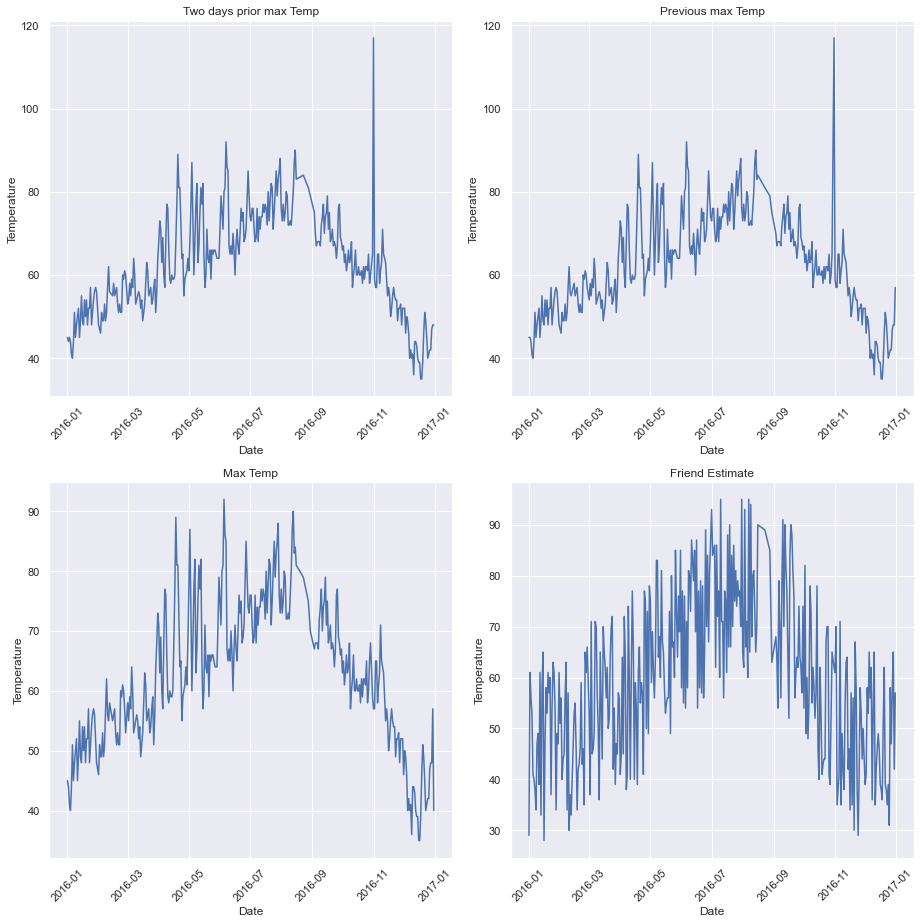

In [175]:
visualize_temp(features)

In [176]:
outliers = dp.Outliers()

In [177]:
outliers.fit(features.drop('week', axis = 1), verbose = True);

0 outliers were found
0 outliers were found
0 outliers were found
1 outliers were found
1 outliers were found
0 outliers were found
0 outliers were found
0 outliers were found
0 outliers were found


In [178]:
def f_to_c(temp):
    return (5 / 9) * (temp - 32)

In [179]:
temp_cols = ['temp_1', 'temp_2', 'actual', 'average', 'friend']

In [180]:
for c in temp_cols:
    features[c] = features[c].apply(f_to_c)

In [181]:
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend,Date
0,2016,1,1,Fri,7.222222,7.222222,7.555556,7.222222,-1.666667,2016-01-01
1,2016,1,2,Sat,6.666667,7.222222,7.611111,6.666667,16.111111,2016-01-02
2,2016,1,3,Sun,7.222222,6.666667,7.666667,5.000000,13.333333,2016-01-03
3,2016,1,4,Mon,6.666667,5.000000,7.722222,4.444444,11.666667,2016-01-04
4,2016,1,5,Tues,5.000000,4.444444,7.777778,6.666667,5.000000,2016-01-05


In [182]:
features.describe()

,year,month,day,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,17.029055,17.056194,15.422573,16.968391,15.574713
std,0.0,3.498380,8.772982,6.758555,6.733635,5.848504,6.552303,8.681211
min,2016.0,1.000000,1.000000,1.666667,1.666667,7.277778,1.666667,-2.222222
25%,2016.0,3.000000,8.000000,12.222222,12.222222,9.986111,12.222222,8.750000
50%,2016.0,6.000000,15.000000,16.944444,16.944444,14.555556,16.944444,15.555556
75%,2016.0,10.000000,23.000000,21.666667,21.666667,20.569444,21.666667,21.666667
max,2016.0,12.000000,31.000000,47.222222,47.222222,25.222222,33.333333,35.000000


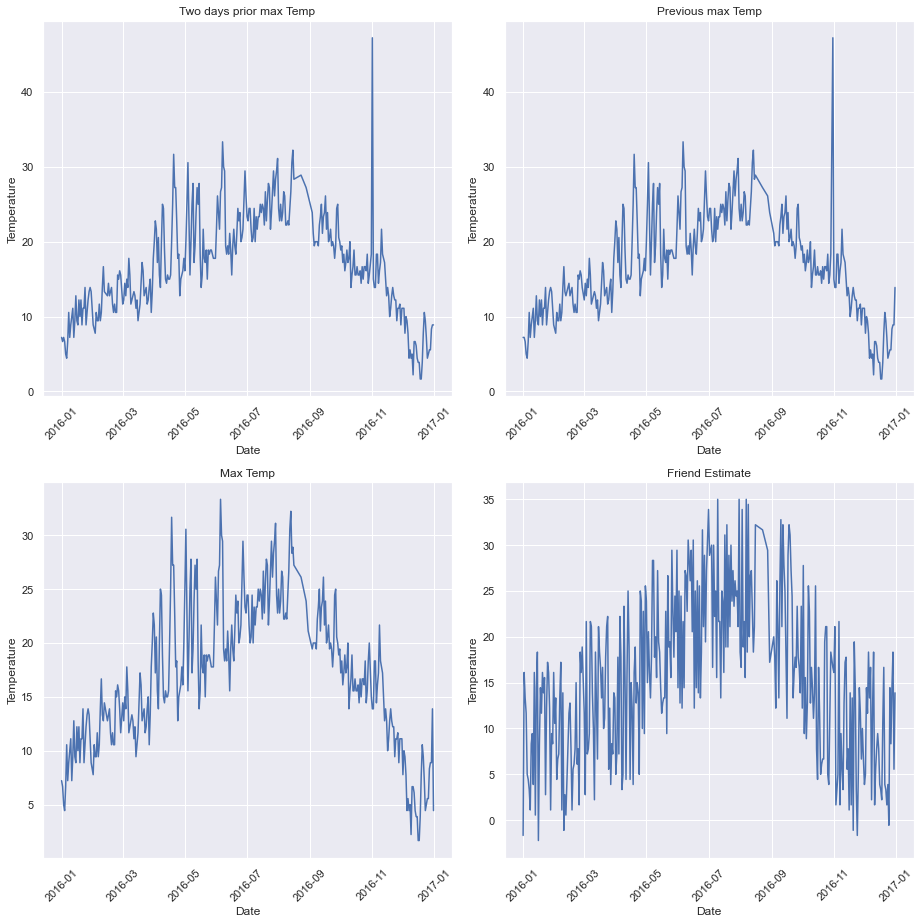

In [183]:
visualize_temp(features)

In [184]:
features_clean = outliers.fit(features.drop('week', axis = 1))[0]

In [185]:
features_clean['week'] = features['week']

In [186]:
features_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   year     348 non-null    int64         
 1   month    348 non-null    int64         
 2   day      348 non-null    int64         
 3   temp_2   347 non-null    float64       
 4   temp_1   347 non-null    float64       
 5   average  348 non-null    float64       
 6   actual   348 non-null    float64       
 7   friend   348 non-null    float64       
 8   Date     348 non-null    datetime64[ns]
 9   week     348 non-null    object        
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 27.3+ KB


In [187]:
features_clean['temp_2'].fillna(method = 'backfill', inplace = True)
features_clean['temp_1'].fillna(method = 'backfill', inplace = True)

In [188]:
features_clean.head()

,year,month,day,temp_2,temp_1,average,actual,friend,Date,week
0,2016,1,1,7.222222,7.222222,7.555556,7.222222,-1.666667,2016-01-01,Fri
1,2016,1,2,6.666667,7.222222,7.611111,6.666667,16.111111,2016-01-02,Sat
2,2016,1,3,7.222222,6.666667,7.666667,5.000000,13.333333,2016-01-03,Sun
3,2016,1,4,6.666667,5.000000,7.722222,4.444444,11.666667,2016-01-04,Mon
4,2016,1,5,5.000000,4.444444,7.777778,6.666667,5.000000,2016-01-05,Tues


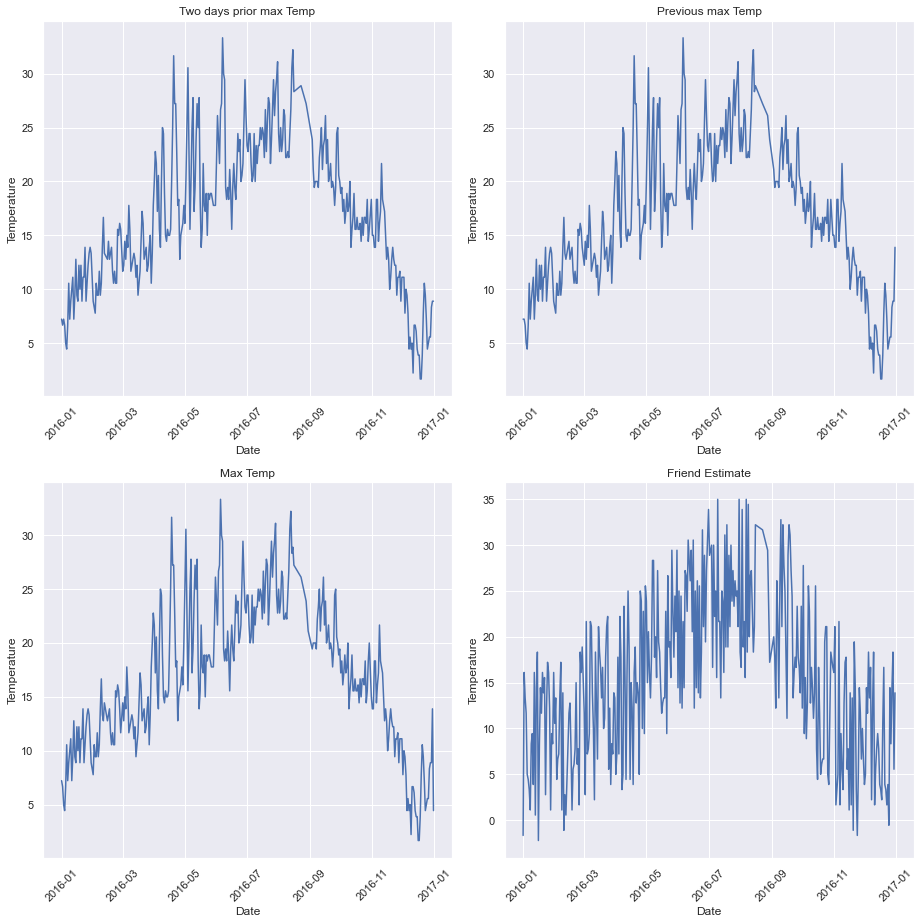

In [189]:
visualize_temp(features_clean)

## One-Hot Encoding

In [190]:
features = dp.dummies_variables(features_clean, ['week'])

In [191]:
features.head()

,year,month,day,temp_2,temp_1,average,actual,friend,Date,week,Mon,Sat,Sun,Thurs,Tues,Wed
0,2016,1,1,7.222222,7.222222,7.555556,7.222222,-1.666667,2016-01-01,Fri,0,0,0,0,0,0
1,2016,1,2,6.666667,7.222222,7.611111,6.666667,16.111111,2016-01-02,Sat,0,1,0,0,0,0
2,2016,1,3,7.222222,6.666667,7.666667,5.000000,13.333333,2016-01-03,Sun,0,0,1,0,0,0
3,2016,1,4,6.666667,5.000000,7.722222,4.444444,11.666667,2016-01-04,Mon,1,0,0,0,0,0
4,2016,1,5,5.000000,4.444444,7.777778,6.666667,5.000000,2016-01-05,Tues,0,0,0,0,1,0


In [192]:
features.drop(['week', 'Date'], axis = 1, inplace = True)

In [193]:
features.head()

,year,month,day,temp_2,temp_1,average,actual,friend,Mon,Sat,Sun,Thurs,Tues,Wed
0,2016,1,1,7.222222,7.222222,7.555556,7.222222,-1.666667,0,0,0,0,0,0
1,2016,1,2,6.666667,7.222222,7.611111,6.666667,16.111111,0,1,0,0,0,0
2,2016,1,3,7.222222,6.666667,7.666667,5.000000,13.333333,0,0,1,0,0,0
3,2016,1,4,6.666667,5.000000,7.722222,4.444444,11.666667,1,0,0,0,0,0
4,2016,1,5,5.000000,4.444444,7.777778,6.666667,5.000000,0,0,0,0,1,0


In [194]:
features.shape

(348, 14)

We separate into target and predictors

In [195]:
X = features.drop('actual', axis = 1).values

In [196]:
y = features['actual'].values

Training and testing

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)

In [198]:
X_train.shape, X_test.shape

((243, 13), (105, 13))

## Training the model

In [199]:
model = RandomForestRegressor(n_estimators = 1000, random_state = 21)

In [200]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=21)

## Make Predictions

In [201]:
predict = model.predict(X_test)

## Evaluate

In [202]:
model.score(X_test, y_test)

0.8300302725775843

## MAE

In [203]:
from sklearn.metrics import mean_absolute_error

In [204]:
mean_absolute_error(y_test, predict)

2.0441428571428704

In [205]:
from sklearn.metrics import mean_absolute_percentage_error

In [206]:
mape = mean_absolute_percentage_error(y_test, predict)
mape

0.13480021918312263

In [207]:
print('Accuracy: {} %'.format(round(100 - 100 * mape, 2)))

Accuracy: 86.52 %


In [208]:
features_clean['predictions1'] = model.predict(X)

## Grid Search

In [209]:
from sklearn.model_selection import GridSearchCV

In [210]:
hipper = {'criterion' : ['mse', 'mae'],
         'max_depth' : [None, 5, 7, 10],
         'min_samples_split' : [2, 10, 20],
         'max_features': ["auto", "sqrt", "log2"]}

In [211]:
model = RandomForestRegressor()

In [212]:
gs = GridSearchCV(model, hipper, cv = 10)

In [213]:
gs.fit(X, y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [None, 5, 7, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 10, 20]})

In [214]:
gs.best_score_

0.24464465147461795

In [215]:
gs.best_params_

{'criterion': 'mae',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 10}

In [216]:
model2 = RandomForestRegressor(n_estimators = 1000, criterion = 'mae', max_depth = 5, min_samples_split = 10)

In [217]:
model2.fit(X_train, y_train)

RandomForestRegressor(criterion='mae', max_depth=5, min_samples_split=10,
                      n_estimators=1000)

In [218]:
predict2 = model2.predict(X_test)

In [219]:
model2.score(X_test, y_test)

0.834744405135686

In [220]:
mean_absolute_error(y_test, predict2)

2.0197486772486846

In [221]:
mape = mean_absolute_percentage_error(y_test, predict2)
mape

0.13145289037401756

In [222]:
print('Accuracy: {} %'.format(round(100 - 100 * mape, 2)))

Accuracy: 86.85 %


In [223]:
features_clean['predictions2'] = model2.predict(X)

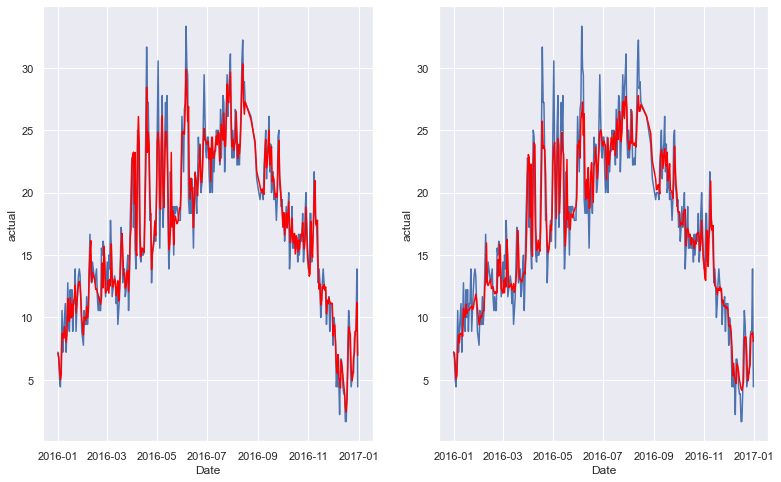

In [224]:
fig, ax = plt.subplots(1, 2, figsize = (13, 8))

sns.lineplot(data = features_clean, x = 'Date', y = 'actual', ax = ax[0])
sns.lineplot(data = features_clean, x = 'Date', y = 'predictions1', ax = ax[0], color = 'red')

sns.lineplot(data = features_clean, x = 'Date', y = 'actual', ax = ax[1])
sns.lineplot(data = features_clean, x = 'Date', y = 'predictions2', ax = ax[1], color = 'red');